<a href="https://www.kaggle.com/code/jonathanma02/titanic-dataset?scriptVersionId=100863697" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# finding data set locale
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
combined = [train_df, test_df] 

### Deep Neural Network Implementation for Predicting Titanic Passenger Survivorship
#### Written by Jonathan Ma - 06/17/2022

In [3]:
train_df.tail(5) # Previewing data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# Data Dictionary
| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |  |
| Age | Age in years |  |
| sibsp | # of siblings / spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  | 
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


# Classifying Data
#### Categorical Data
- Ordinal Data: pclass
- Nominal Data: embarked, survived, sex, name


#### Numerical Data
- Discrete Data: age, sibsp, parch
- Continuous Data: fare


#### Mixed Data
- cabin: Latin letter followed by a number
- ticket: Mix of numbers and Latin strings followed by numbers
    

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


**We will drop name, cabin number, and passenger ID from our training examples.**


- Name likely has no bearing on survivorship, and it is unique to every passenger

- Cabin numbers are unusable; out of 891 training examples, 204 have cabin numbers

- Passenger ID is used for Kaggle data submission

### **Preliminary Data Analysis**

In [6]:
train_df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [7]:
train_df[["Sex","Survived"]].groupby(["Sex"], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


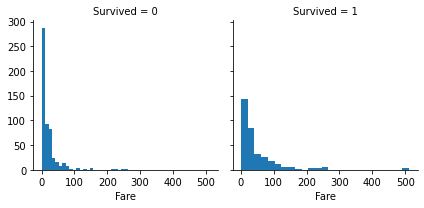

In [8]:
fare_histogram = sns.FacetGrid(train_df, col = "Survived")
fare_histogram.map(plt.hist, "Fare", bins=25)

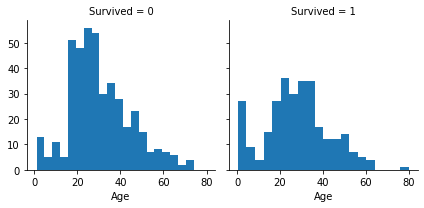

In [9]:
age_histogram = sns.FacetGrid(train_df, col = "Survived")
age_histogram.map(plt.hist, "Age", bins = 20)

In [10]:
train_df[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


With our preliminary data analysis, we have that:


- Gender played a vital role in survivorship in the Titanic (74% of females survived vs. ~19% of males)
- Passenger class also heavily affected survivorship (63% of First class passengers survived vs. 24% in Third class)
- A lower fare correlated to a lower survival rate.
- Infants had a greater chance of survival on the Titanic.
- Port of embarkment played a role in survivorship.


We will continue by dropping some features in our data set.

In [11]:
train_df.drop(["Ticket", "Cabin"], axis=1)
test_df.drop(["Ticket", "Cabin"], axis=1)
combine = [train_df, test_df]

# Feature Engineering

### Motivation:
During the early 20th century, certain titles were a rare commodity amongst commmon folk. Typically, titles such as Dr. or Sir. were reserved for higher class members of society. We will take advantage of the fact that our data set contains names which include titles if a passenger had one, and create a new input feature named "Title." Luckily, this will only take a small amount of globbing, as the titles typically ended with a period.

In [12]:
for i in combine:
    i["Title"] = i.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df["Title"], train_df["Sex"])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We will go ahead and group together the rarer titles in a category called "Exotic". We will also clean up the data by anglicizing the titles.

In [13]:
for i in combine:
    i["Title"] = i["Title"].replace(["Lady", "Countess", "Capt", "Col",
                                     "Don", "Dr", "Major", "Rev", "Sir",
                                     "Jonkheer", "Dona"], "Exotic")
    i["Title"] = i["Title"].replace("Mlle", "Miss")
    i["Title"] = i["Title"].replace("Ms", "Miss")
    i["Title"] = i["Title"].replace("Mme", "Mrs")
    
train_df[["Title", "Survived"]].groupby(["Title"], as_index=False).mean()

,Title,Survived
0,Exotic,0.347826
1,Master,0.575000
2,Miss,0.702703
3,Mr,0.156673
4,Mrs,0.793651


As expected, the feminine titles had higher survival rates, and the more "High Society" titles had higher survival rates than commoner titles. We will convert these categorical titles to ordinal titles by survival rate.

In [14]:
title_map = {"Mr": 1, "Exotic": 2, "Master": 3, "Miss": 4, "Mrs": 5}
for i in combine:
    i["Title"] = i["Title"].map(title_map)
    i["Title"] = i["Title"].fillna(0)
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,4
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,1
